In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import os
import math
import csv
import random
import pickle
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.linear_model import SGDClassifier
import xgboost as xgb

plt.style.use("fivethirtyeight") 
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['axes.titlesize'] = 20
matplotlib.rcParams['xtick.labelsize'] = 15
matplotlib.rcParams['ytick.labelsize'] = 15

In [3]:

data_raw = pd.read_csv("train.csv")
data_raw.head()

,source_node,destination_node
0,1,690569
1,1,315892
2,1,189226
3,2,834328
4,2,1615927


In [4]:
print("Number of edge connections =",data_raw.shape[0])

Number of edge connections = 9437519


In [5]:
#sampling 300k data-points due to constraints in computation power
data_raw = data_raw[0:300000]
print("Number of edge connections =",data_raw.shape[0])

Number of edge connections = 300000


In [6]:
#removing columns names and index then saving the file
data_raw.to_csv("Train_New.csv", header = False, index = False)


In [8]:
#creating directed graph of whole data
G = nx.read_edgelist("Train_New.csv", delimiter = ",", create_using = nx.DiGraph(), nodetype = int)
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 279652
Number of edges: 300000
Average in degree:   1.0728
Average out degree:   1.0728


__1.2 Plotting Sub Graph__

Name: 
Type: DiGraph
Number of nodes: 97
Number of edges: 75
Average in degree:   0.7732
Average out degree:   0.7732


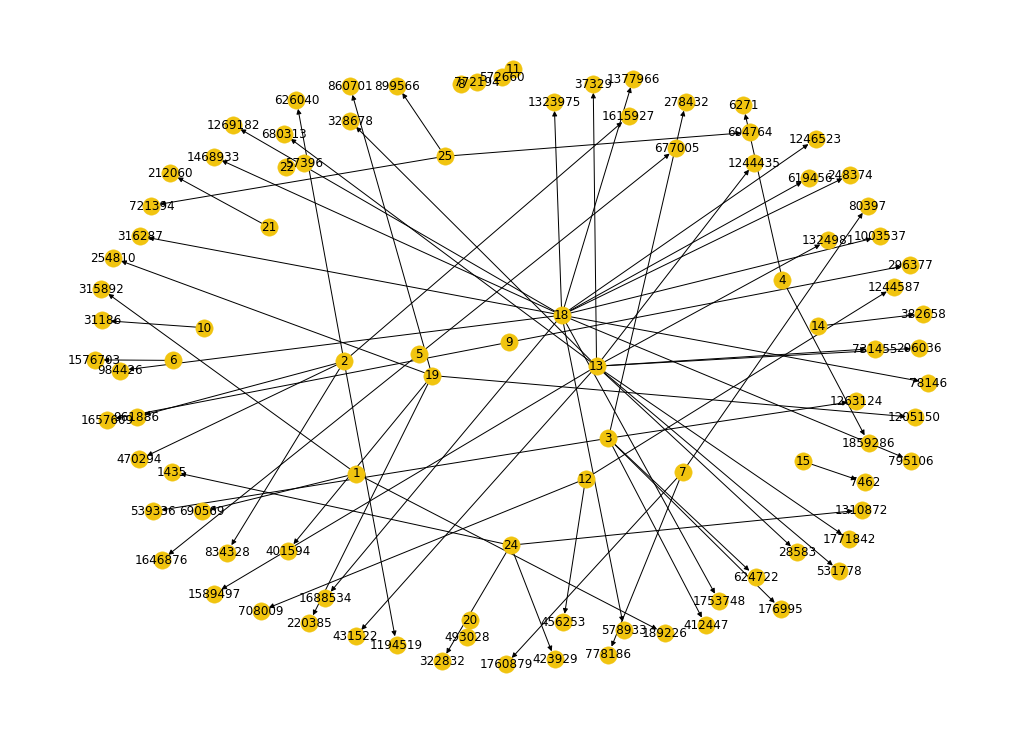

In [10]:
pd.read_csv("train.csv", nrows = 75).to_csv("Train_Sample.csv", header = False, index = False)
subGraph = nx.read_edgelist("Train_Sample.csv", delimiter = ",", create_using = nx.DiGraph(), nodetype = int)
print(nx.info(subGraph))
plt.figure(figsize = (14, 10))
nx.draw(G = subGraph, pos = nx.spring_layout(subGraph), with_labels = True, node_color = '#F1C40F')

__1.3 Number of unique persons__

In [11]:
print("Total number of unique persons =",len(G.nodes()))

Total number of unique persons = 279652


__1.4 Number of followers of each person (In-Degree)__

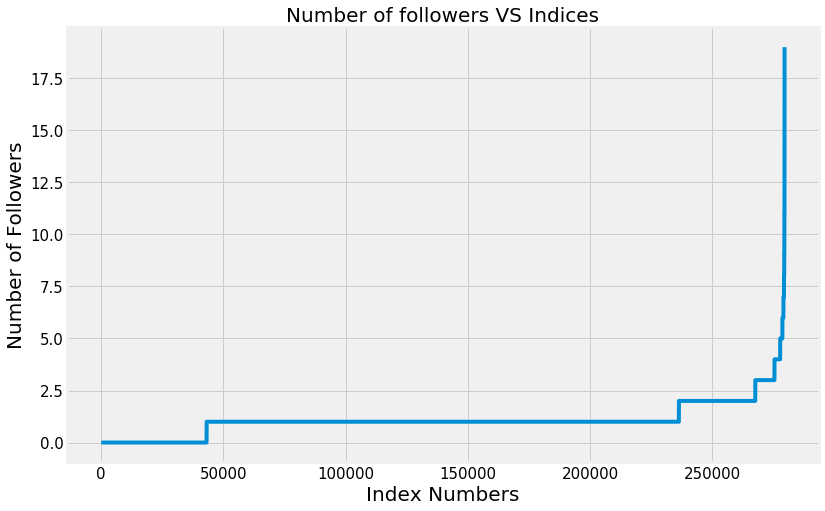

In [12]:
indegreeValues = list(dict(G.in_degree()).values())
indegreeValues.sort()
plt.figure(figsize = (12,8))
plt.title("Number of followers VS Indices")
plt.ylabel("Number of Followers")
plt.xlabel("Index Numbers")
plt.plot(indegreeValues)
plt.show()

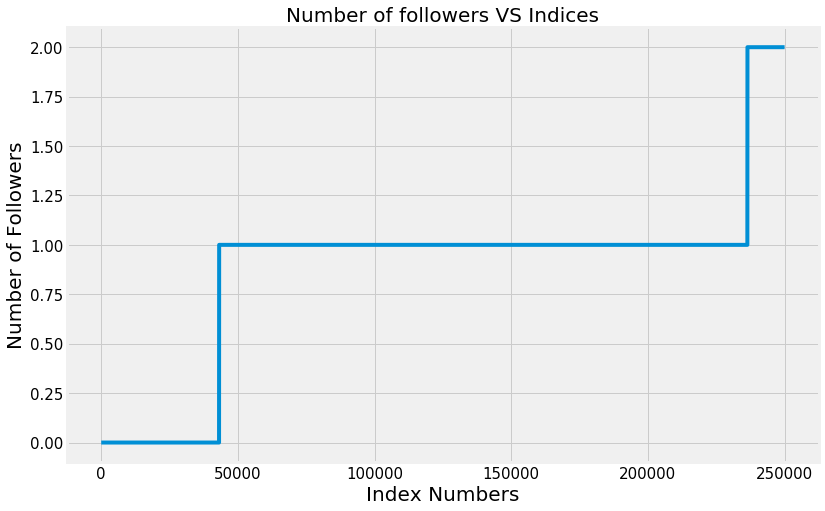

In [13]:
indegreeValues = list(dict(G.in_degree()).values())
indegreeValues.sort()
indegreeValues = indegreeValues[:250000]
plt.figure(figsize = (12,8))
plt.title("Number of followers VS Indices")
plt.ylabel("Number of Followers")
plt.xlabel("Index Numbers")
plt.plot(indegreeValues)
plt.show()

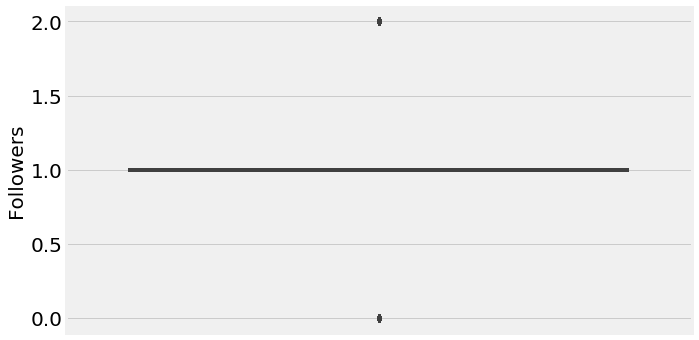

In [14]:
fig = plt.figure(figsize = (10,6))
ax = sns.boxplot(indegreeValues, orient = "v")

plt.tick_params(labelsize = 20)
plt.ylabel("Followers", fontsize = 20)
plt.show()

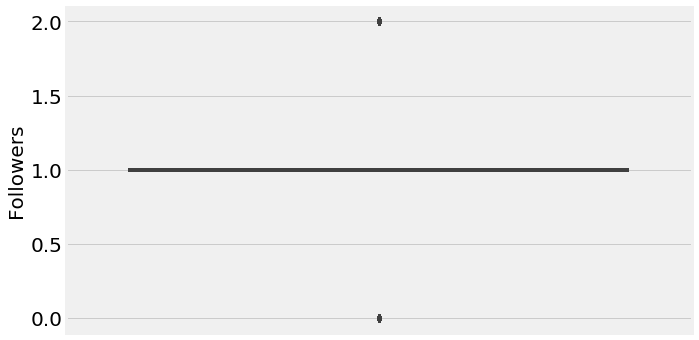

In [15]:
indegreeValues = indegreeValues[:250000]
fig = plt.figure(figsize = (10,6))
ax = sns.boxplot(indegreeValues, orient = "v")

plt.tick_params(labelsize = 20)
plt.ylabel("Followers", fontsize = 20)
plt.show()


In [16]:
indegree_series = pd.Series(indegreeValues)
quantile_values = indegree_series.quantile(np.arange(0.90, 1.01, 0.01))
for i in range(len(quantile_values)):
    print("{}th percentile value = {}".format(np.round(list(quantile_values.keys())[i]*100, 1), quantile_values[list(quantile_values.keys())[i]]))


90.0th percentile value = 1.0
91.0th percentile value = 1.0
92.0th percentile value = 1.0
93.0th percentile value = 1.0
94.0th percentile value = 1.0
95.0th percentile value = 2.0
96.0th percentile value = 2.0
97.0th percentile value = 2.0
98.0th percentile value = 2.0
99.0th percentile value = 2.0
100.0th percentile value = 2.0


In [17]:
indegree_series = pd.Series(indegreeValues)
quantile_values = indegree_series.quantile(np.arange(0.99, 1.001, 0.001))
for i in range(len(quantile_values)):
    print("{}th percentile value = {}".format(np.round(list(quantile_values.keys())[i]*100, 1), quantile_values[list(quantile_values.keys())[i]]))

99.0th percentile value = 2.0
99.1th percentile value = 2.0
99.2th percentile value = 2.0
99.3th percentile value = 2.0
99.4th percentile value = 2.0
99.5th percentile value = 2.0
99.6th percentile value = 2.0
99.7th percentile value = 2.0
99.8th percentile value = 2.0
99.9th percentile value = 2.0
100.0th percentile value = 2.0


In [18]:
indegree_series = pd.Series(indegreeValues)
quantile_values = indegree_series.quantile(np.arange(0.999, 1.0001, 0.0001))
for i in range(len(quantile_values)):
    print("{}th percentile value = {}".format(np.round(list(quantile_values.keys())[i]*100, 2), quantile_values[list(quantile_values.keys())[i]]))

99.9th percentile value = 2.0
99.91th percentile value = 2.0
99.92th percentile value = 2.0
99.93th percentile value = 2.0
99.94th percentile value = 2.0
99.95th percentile value = 2.0
99.96th percentile value = 2.0
99.97th percentile value = 2.0
99.98th percentile value = 2.0
99.99th percentile value = 2.0
100.0th percentile value = 2.0


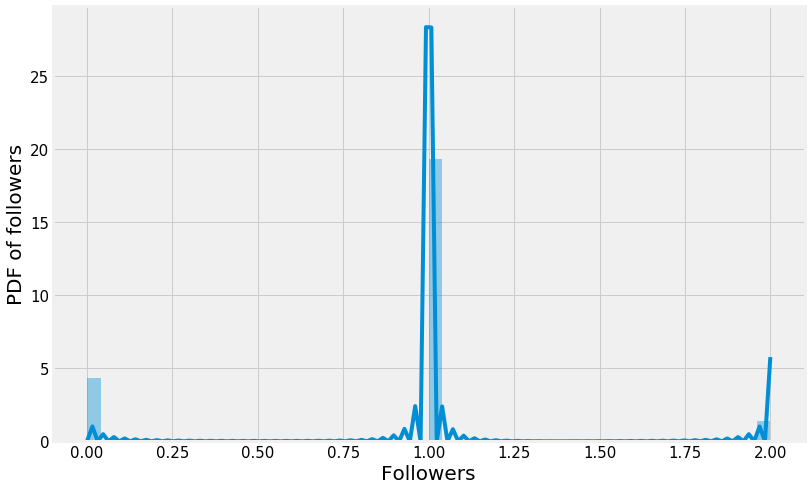

In [19]:
fig = plt.figure(figsize = (12,8))
sns.distplot(indegree_series)
plt.ylabel("PDF of followers")
plt.xlabel("Followers")

Observation:
Above plots shows that almost 99% of people have less than 4 followers and very few people have high number of followers

__1.5 Number of people each person is following (Out-Degree)__

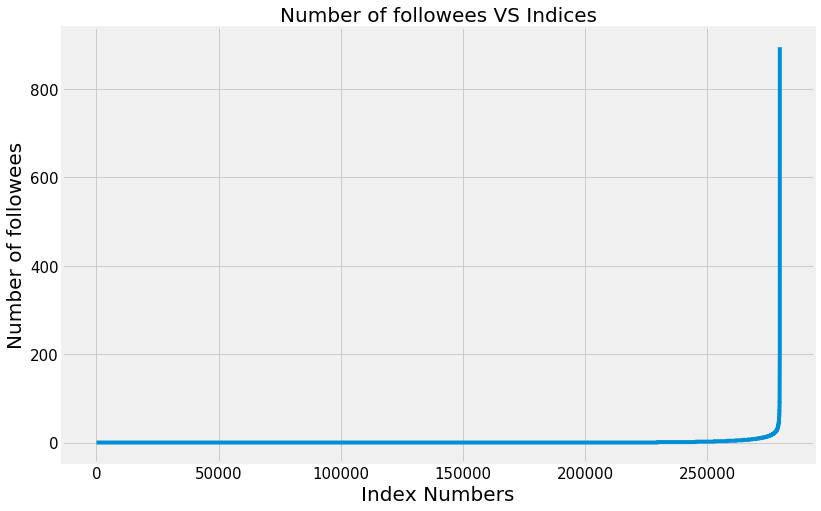

In [20]:
outdegreeValues = list(dict(G.out_degree()).values())
outdegreeValues.sort()
plt.figure(figsize = (12,8))
plt.title("Number of followees VS Indices")
plt.ylabel("Number of followees")
plt.xlabel("Index Numbers")
plt.plot(outdegreeValues)
plt.show()

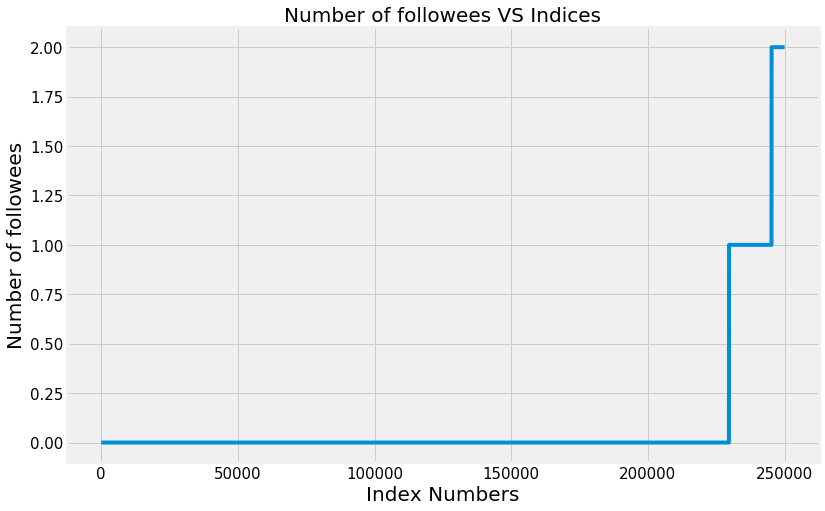

In [21]:
outdegreeValues = list(dict(G.out_degree()).values())
outdegreeValues.sort()
outdegreeValues = outdegreeValues[:250000]
plt.figure(figsize = (12,8))
plt.title("Number of followees VS Indices")
plt.ylabel("Number of followees")
plt.xlabel("Index Numbers")
plt.plot(outdegreeValues)
plt.show()

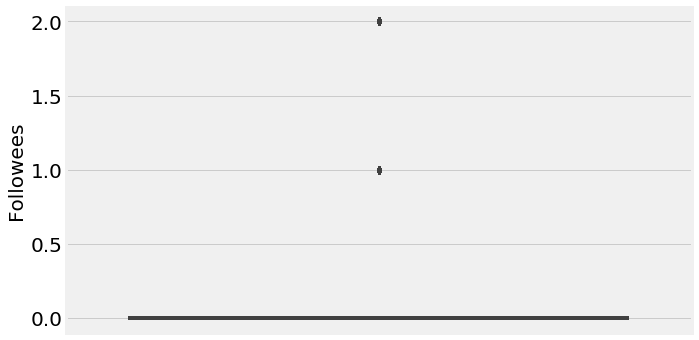

In [22]:
fig = plt.figure(figsize = (10,6))
ax = sns.boxplot(outdegreeValues, orient = "v")

plt.tick_params(labelsize = 20)
plt.ylabel("Followees", fontsize = 20)
plt.show()

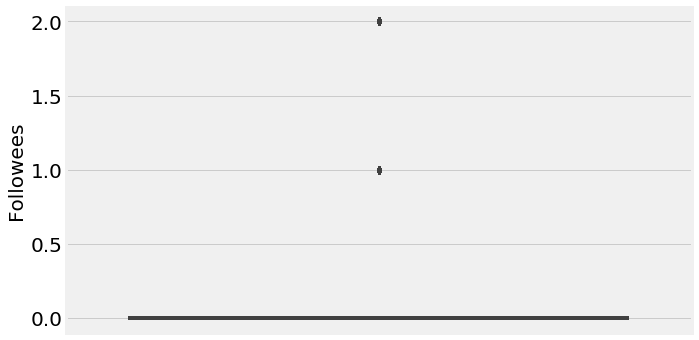

In [23]:
outdegreeValues = outdegreeValues[:250000]
fig = plt.figure(figsize = (10,6))
ax = sns.boxplot(outdegreeValues, orient = "v")

plt.tick_params(labelsize = 20)
plt.ylabel("Followees", fontsize = 20)
plt.show()

In [24]:
outdegree_series = pd.Series(outdegreeValues)
quantile_values = outdegree_series.quantile(np.arange(0.90, 1.01, 0.01))
for i in range(len(quantile_values)):
    print("{}th percentile value = {}".format(np.round(list(quantile_values.keys())[i]*100, 1), quantile_values[list(quantile_values.keys())[i]]))

90.0th percentile value = 0.0
91.0th percentile value = 0.0
92.0th percentile value = 1.0
93.0th percentile value = 1.0
94.0th percentile value = 1.0
95.0th percentile value = 1.0
96.0th percentile value = 1.0
97.0th percentile value = 1.0
98.0th percentile value = 1.0
99.0th percentile value = 2.0
100.0th percentile value = 2.0


In [25]:
outdegree_series = pd.Series(outdegreeValues)
quantile_values = outdegree_series.quantile(np.arange(0.99, 1.001, 0.001))
for i in range(len(quantile_values)):
    print("{}th percentile value = {}".format(np.round(list(quantile_values.keys())[i]*100, 1), quantile_values[list(quantile_values.keys())[i]]))

99.0th percentile value = 2.0
99.1th percentile value = 2.0
99.2th percentile value = 2.0
99.3th percentile value = 2.0
99.4th percentile value = 2.0
99.5th percentile value = 2.0
99.6th percentile value = 2.0
99.7th percentile value = 2.0
99.8th percentile value = 2.0
99.9th percentile value = 2.0
100.0th percentile value = 2.0


In [26]:
outdegree_series = pd.Series(outdegreeValues)
quantile_values = outdegree_series.quantile(np.arange(0.999, 1.0001, 0.0001))
for i in range(len(quantile_values)):
    print("{}th percentile value = {}".format(np.round(list(quantile_values.keys())[i]*100, 2), quantile_values[list(quantile_values.keys())[i]]))

99.9th percentile value = 2.0
99.91th percentile value = 2.0
99.92th percentile value = 2.0
99.93th percentile value = 2.0
99.94th percentile value = 2.0
99.95th percentile value = 2.0
99.96th percentile value = 2.0
99.97th percentile value = 2.0
99.98th percentile value = 2.0
99.99th percentile value = 2.0
100.0th percentile value = 2.0


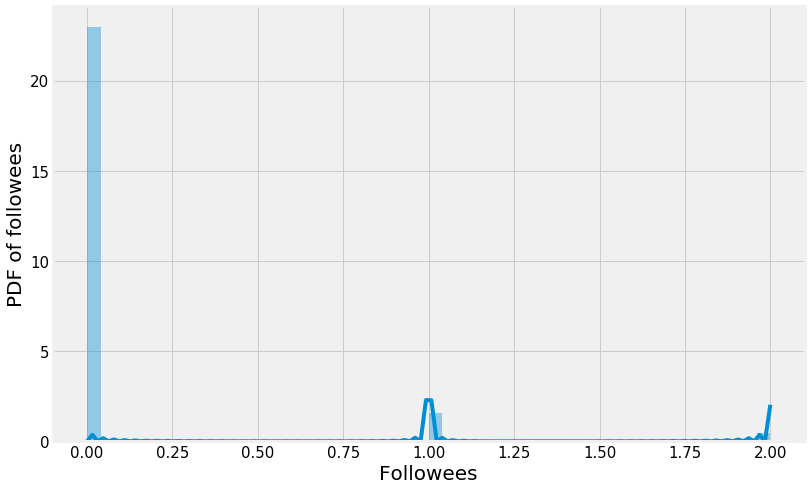

In [27]:

fig = plt.figure(figsize = (12,8))
sns.distplot(outdegree_series)
plt.ylabel("PDF of followees")
plt.xlabel("Followees")


Observation:
Above plots shows that almost 99% of people have less than 19 followees and very few people have high number of followees. Here, the data is more steeper than followers data. Here, extremely few people follow high number of peoples.

1.6 Facts about followers and followee


In [28]:
print("Total number of people who are not followed by anyone = {} ({}%)".format(len(indegree_series) - np.count_nonzero(indegree_series), (len(indegree_series) - np.count_nonzero(indegree_series))/len(indegree_series)*100))

Total number of people who are not followed by anyone = 43099 (17.2396%)


In [29]:
print("Total number of people who are not following anyone = {} ({}%)".format(len(outdegree_series) - np.count_nonzero(outdegree_series), (len(outdegree_series) - np.count_nonzero(outdegree_series))/len(outdegree_series)*100))


Total number of people who are not following anyone = 229640 (91.85600000000001%)


__2. Posing Problem as a Classification Problem.__


__2.1 Generating equal number of edges which are not present in graph for supervised learning__\

In [31]:
def creatingMissingLinks():
    start = datetime.now()
    alreadPresentCheck = dict()
    eachVal = csv.reader(open("Train_New.csv", 'r'))
    for i in eachVal:
        alreadPresentCheck[(i[0], i[1])] = 1
        
    num_edges = G.number_of_edges()
    num_nodes = G.number_of_nodes()
    missing_edges = set()
    
    while (len(missing_edges) < num_edges):
        sourceEdge = random.randint(1, num_nodes)
        destEdge = random.randint(1, num_nodes)
        toCheck = alreadPresentCheck.get((sourceEdge, destEdge), -1)
        
        if toCheck == -1 and sourceEdge != destEdge:
            try:
                if nx.shortest_path_length(G, source = sourceEdge, target = destEdge) > 2:
                    missing_edges.add((sourceEdge, destEdge))
                else:
                    continue
            except:
                missing_edges.add((sourceEdge, destEdge))
        else:
            continue
        #here, above except block will run if there is no path exists between "sourceEdge" and "destEdge" as in this case try
        #block will give error and hence except block will execute and it will add the path in missing_edges. It could be the
        #case, let say 3 people just joined facebook and they are just friends of each other, in this case non of them is 
        #connected to the global graph of facebook hence we cannot reach to these 3 people on facebook from any node of the 
        #global graph.
    
    print("Total Time taken = {}sec".format(datetime.now() - start))
    return missing_edges

missing_edges = creatingMissingLinks()
print(len(missing_edges))

Total Time taken = 0:00:02.632292sec
300000


In [32]:
data_raw['labels'] = np.ones(len(data_raw))
data_missingLinks = pd.DataFrame(list(missing_edges), columns=['source_node', 'destination_node'])
data_missingLinks['labels'] = np.zeros(len(data_missingLinks))
print(data_raw.shape)
print(data_missingLinks.shape)


(300000, 3)
(300000, 3)


In [33]:
data_raw.head()

,source_node,destination_node,labels
0,1,690569,1.0
1,1,315892,1.0
2,1,189226,1.0
3,2,834328,1.0
4,2,1615927,1.0


In [34]:
data_missingLinks.head()

,source_node,destination_node,labels
0,129376,83137,0.0
1,138917,221929,0.0
2,261617,24549,0.0
3,27731,123881,0.0
4,37842,213283,0.0


In [35]:
fullFrame = [data_raw, data_missingLinks]
completeData = pd.concat(fullFrame)
completeData = completeData.sort_values('source_node')
completeData.reset_index(drop = True, inplace = True)
completeData.to_csv("CompleteData.csv", index = False)
print(completeData.shape)

(600000, 3)


In [36]:
completeData.head()

,source_node,destination_node,labels
0,1,690569,1.0
1,1,315892,1.0
2,1,189226,1.0
3,2,834328,1.0
4,2,1615927,1.0


In [37]:
completeData['labels'].value_counts()

1.0    300000
0.0    300000
Name: labels, dtype: int64

In [38]:
completeDataForGraph = completeData.drop('labels', axis = 1)
completeDataForGraph.to_csv("CompleteDataForGraph.csv", header = False, index = False)

# 3. Featurization

In [39]:
if os.path.isfile("CompleteDataForGraph.csv"):
    completeDataGraph =  nx.read_edgelist("CompleteDataForGraph.csv", delimiter = ",", create_using = nx.DiGraph(), nodetype = int)

print(nx.info(completeDataGraph))

Name: 
Type: DiGraph
Number of nodes: 456956
Number of edges: 600000
Average in degree:   1.3130
Average out degree:   1.3130


__3.1 Jaccard Distance__
https://www.statisticshowto.com/jaccard-index/

In [40]:
def jaccard_followees(s,d):
    try:
        if (len(set(completeDataGraph.successors(s))) == 0) or (len(set(completeDataGraph.successors(d))) == 0):
            return 0
        else:
            jf = (len(set(completeDataGraph.successors(s)).intersection(set(completeDataGraph.successors(d))))) / (len(set(completeDataGraph.successors(s)).union(set(completeDataGraph.successors(d)))))
            return jf
    except:
        return 0
    #if a node does not exists in graph then except block will run
    #A successor of n is a node m such that there exists a directed edge from n to m.
    

def jaccard_followers(s,d):
    try:
        if (len(set(completeDataGraph.predecessors(s))) == 0) or (len(set(completeDataGraph.predecessors(d))) == 0):
            return 0
        else:
            jf = (len(set(completeDataGraph.predecessors(s)).intersection(set(completeDataGraph.predecessors(d))))) / (len(set(completeDataGraph.predecessors(s)).union(set(completeDataGraph.predecessors(d)))))
            return jf
    except:
        return 0
    #if a node does not exists in graph then except block will run
    #A predecessor of n is a node m such that there exists a directed edge from m to n.

In [41]:
completeData['JaccardFollowers'] = completeData.apply(lambda row: jaccard_followers(row['source_node'], row['destination_node']), axis = 1)
completeData['JaccardFollowees'] = completeData.apply(lambda row: jaccard_followees(row['source_node'], row['destination_node']), axis = 1)
completeData.head()

,source_node,destination_node,labels,JaccardFollowers,JaccardFollowees
0,1,690569,1.0,0.0,0.0
1,1,315892,1.0,0.0,0.0
2,1,189226,1.0,0.0,0.0
3,2,834328,1.0,0.0,0.0
4,2,1615927,1.0,0.0,0.0


In [42]:
completeData.to_csv("CompleteDataWithFeat.csv", index = False)
print("Max of Jaccard Followers =",max(completeData['JaccardFollowers']))
print("Min of Jaccard Followers =",min(completeData['JaccardFollowers']))
print("Max of Jaccard Followees =",max(completeData['JaccardFollowees']))
print("Min of Jaccard Followees =",min(completeData['JaccardFollowees']))

Max of Jaccard Followers = 0.9
Min of Jaccard Followers = 0.0
Max of Jaccard Followees = 0.9661016949152542
Min of Jaccard Followees = 0.0


__3.2 Cosine Distance (Otsuka-Ochiai coefficient)__

In [43]:
def cosine_distance_followees(s,d):
    try:
        if (len(set(completeDataGraph.successors(s))) == 0) or (len(set(completeDataGraph.successors(d))) == 0):
            return 0
        else:
            cdf = (len(set(completeDataGraph.successors(s)).intersection(set(completeDataGraph.successors(d))))) / (math.sqrt(len(set(completeDataGraph.successors(s))) * len(set(completeDataGraph.successors(d)))))
            return cdf
    except:
        return 0
    #if a node does not exists in graph then except block will run
    
    
def cosine_distance_followers(s,d):
    try:
        if (len(set(completeDataGraph.predecessors(s))) == 0) or (len(set(completeDataGraph.predecessors(d))) == 0):
            return 0
        else:
            cdf = (len(set(completeDataGraph.predecessors(s)).intersection(set(completeDataGraph.predecessors(d))))) / (math.sqrt(len(set(completeDataGraph.predecessors(s))) * len(set(completeDataGraph.predecessors(d)))))
            return cdf
    except:
        return 0
    #if a node does not exists in graph then except block will run

In [44]:
completeData['CosineDistanceFollowers'] = completeData.apply(lambda row: cosine_distance_followers(row['source_node'], row['destination_node']), axis = 1)
completeData['CosineDistanceFollowees'] = completeData.apply(lambda row: cosine_distance_followees(row['source_node'], row['destination_node']), axis = 1)
completeData.head()

,source_node,destination_node,labels,JaccardFollowers,JaccardFollowees,CosineDistanceFollowers,CosineDistanceFollowees
0,1,690569,1.0,0.0,0.0,0.0,0.0
1,1,315892,1.0,0.0,0.0,0.0,0.0
2,1,189226,1.0,0.0,0.0,0.0,0.0
3,2,834328,1.0,0.0,0.0,0.0,0.0
4,2,1615927,1.0,0.0,0.0,0.0,0.0


In [45]:
completeData.to_csv("CompleteDataWithFeat.csv", index = False)
print("Max of Cosine Distance Followers =",max(completeData['CosineDistanceFollowers']))
print("Min of Cosine Distance Followers =",min(completeData['CosineDistanceFollowers']))
print("Max of Cosine Distance Followees =",max(completeData['CosineDistanceFollowees']))
print("Min of Cosine Distance Followees =",min(completeData['CosineDistanceFollowees']))

Max of Cosine Distance Followers = 0.9486832980505138
Min of Cosine Distance Followers = 0.0
Max of Cosine Distance Followees = 0.9827586206896551
Min of Cosine Distance Followees = 0.0


__3.3 Page Rank__

https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank.html

PageRank computes a ranking of the nodes in the graph G based on the structure of the incoming links.



Mathematical PageRanks for a simple network, expressed as percentages. (Google uses a logarithmic scale.) Page C has a higher PageRank than Page E, even though there are fewer links to C; the one link to C comes from an important page and hence is of high value. If web surfers who start on a random page have an 85% likelihood of choosing a random link from the page they are currently visiting, and a 15% likelihood of jumping to a page chosen at random from the entire web, they will reach Page E 8.1% of the time. (The 15% likelihood of jumping to an arbitrary page corresponds to a damping factor of 85%.) Without damping, all web surfers would eventually end up on Pages A, B, or C, and all other pages would have PageRank zero. In the presence of damping, Page A effectively links to all pages in the web, even though it has no outgoing links of its own.

In [46]:
def pageRank():
    pr = nx.pagerank(completeDataGraph)
#   pr_sorted = dict(sorted(pr.items(), key = lambda x: x[1], reverse = True))
    return pr

In [47]:
pr_values = pageRank()
completeData['PageRankSource'] = completeData['source_node'].apply(lambda val: pr_values[val])
completeData['PageRankDest'] = completeData['destination_node'].apply(lambda val: pr_values[val])
completeData.head()

,source_node,destination_node,labels,JaccardFollowers,JaccardFollowees,CosineDistanceFollowers,CosineDistanceFollowees,PageRankSource,PageRankDest
0,1,690569,1.0,0.0,0.0,0.0,0.0,0.000006,0.000002
1,1,315892,1.0,0.0,0.0,0.0,0.0,0.000006,0.000002
2,1,189226,1.0,0.0,0.0,0.0,0.0,0.000006,0.000003
3,2,834328,1.0,0.0,0.0,0.0,0.0,0.000001,0.000002
4,2,1615927,1.0,0.0,0.0,0.0,0.0,0.000001,0.000002


In [48]:
completeData.to_csv("CompleteDataWithFeat.csv", index = False)
print("Max of Page Rank Source =",max(completeData['PageRankSource']))
print("Min of Page Rank Source =",min(completeData['PageRankSource']))
print("Max of Page Rank Destination =",max(completeData['PageRankDest']))
print("Min of Page Rank Destination =",min(completeData['PageRankDest']))

Max of Page Rank Source = 1.2529613819999616e-05
Min of Page Rank Source = 1.3688018381020175e-06
Max of Page Rank Destination = 1.2529613819999618e-05
Min of Page Rank Destination = 1.3708709541535374e-06


__3.4 Shortest Path__

Getting Shortest path between two nodes, if nodes have an edge i.e, trivially connected then we are removing that edge and calculating the shortest path.

In [49]:
def computeShortestPath(s, d):
    sd = -1
    try:
        if completeDataGraph.has_edge(s, d):
            completeDataGraph.remove_edge(s, d)
            try:
                sd = nx.shortest_path_length(completeDataGraph, source = s, target = d)
                train_graph.add_edge(s, d)
            except:
                train_graph.add_edge(s, d)
        else:
            sd = nx.shortest_path_length(completeDataGraph, source = s, target = d)
        return sd
    except:
        return sd

In [50]:
completeData['ShortestPathLength'] = completeData.apply(lambda row: computeShortestPath(row['source_node'], row['destination_node']), axis = 1)
completeData.head()

,source_node,destination_node,labels,JaccardFollowers,JaccardFollowees,CosineDistanceFollowers,CosineDistanceFollowees,PageRankSource,PageRankDest,ShortestPathLength
0,1,690569,1.0,0.0,0.0,0.0,0.0,0.000006,0.000002,-1
1,1,315892,1.0,0.0,0.0,0.0,0.0,0.000006,0.000002,-1
2,1,189226,1.0,0.0,0.0,0.0,0.0,0.000006,0.000003,-1
3,2,834328,1.0,0.0,0.0,0.0,0.0,0.000001,0.000002,-1
4,2,1615927,1.0,0.0,0.0,0.0,0.0,0.000001,0.000002,-1


In [51]:
completeData.to_csv("CompleteDataWithFeat.csv", index = False)
print("Max of Shortest Path =",max(completeData['ShortestPathLength']))
print("Min of Shortest Path =",min(completeData['ShortestPathLength']))

Max of Shortest Path = 217
Min of Shortest Path = -1


__3.5 Checking same component--Community__

In [59]:
wcc = list(nx.weakly_connected_components(completeDataGraph))          
def check_same_wcc(s, d):
    same_wcc = 0
    if completeDataGraph.has_edge(s, d):
        for i in wcc:
            if s in i:
                same_wcc = i
                break
        if d in same_wcc:
            completeDataGraph.remove_edge(s, d)
            if computeShortestPath(s, d) == -1:
                completeDataGraph.add_edge(s, d)
                return 0
            else:
                completeDataGraph.add_edge(s, d)
                return 1
        else:
            return 0
        
    elif completeDataGraph.has_edge(d, s):
        for i in wcc:
            if d in i:
                same_wcc = i
                break
        if s in same_wcc:
            completeDataGraph.remove_edge(d, s)
            if computeShortestPath(d, s) == -1:
                completeDataGraph.add_edge(d, s)
                return 0
            else:
                completeDataGraph.add_edge(d, s)
                return 1
        else:
            return 0
        
    else:
        for i in wcc:
            if s in i:
                same_wcc = i
                break
        if d in same_wcc:
            return 1
        else:
            return 0



In [62]:
wcc = list(nx.weakly_connected_components(completeDataGraph))
def check_same_wcc(s, d):
    same_wcc = 0
    if completeDataGraph.has_edge(s, d):
        for i in wcc:
            if s in i:
                same_wcc = i
                break
        if d in same_wcc:
            completeDataGraph.remove_edge(s, d)
            if computeShortestPath(s, d) == -1:
                completeDataGraph.add_edge(s, d)
                return 0
            else:
                completeDataGraph.add_edge(s, d)
                return 1
        else:
            return 0
        
    elif completeDataGraph.has_edge(d, s):
        for i in wcc:
            if d in i:
                same_wcc = i
                break
        if s in same_wcc:
            completeDataGraph.remove_edge(d, s)
            if computeShortestPath(d, s) == -1:
                completeDataGraph.add_edge(d, s)
                return 0
            else:
                completeDataGraph.add_edge(d, s)
                return 1
        else:
            return 0
        
    else:
        for i in wcc:
            if s in i:
                same_wcc = i
                break
        if d in same_wcc:
            return 1
        else:
            return 0

In [ ]:
completeData['SameComponent'] = completeData.apply(lambda row: check_same_wcc(row['source_node'], row['destination_node']), axis = 1)

In [ ]:
completeData.to_csv("CompleteDataWithFeat.csv", index = False)
print("Number of zeros in Same Component =",len(completeData['SameComponent']) - np.count_nonzero(completeData['SameComponent']))
print("Number of ones in Same Component =",np.count_nonzero(completeData['SameComponent']))

__3.6 Adar Index__

In [64]:
def calc_adar_index(s, d):
    adar_sum = 0
    try:
        common_followers = list(set(completeDataGraph.successors(s)).intersection(set(completeDataGraph.successors(d))))
        if len(common_followers)!=0:
            for i in common_followers:
                adar_sum += 1/np.log10(len(set(completeDataGraph.predecessors(i))))
            return adar_sum
        else:
            return 0
    except:
        return 0

In [65]:
completeData['AdarIndex'] = completeData.apply(lambda row: calc_adar_index(row['source_node'], row['destination_node']), axis = 1)
completeData.head()

,source_node,destination_node,labels,JaccardFollowers,JaccardFollowees,CosineDistanceFollowers,CosineDistanceFollowees,PageRankSource,PageRankDest,ShortestPathLength,AdarIndex
0,1,690569,1.0,0.0,0.0,0.0,0.0,0.000006,0.000002,-1,0
1,1,315892,1.0,0.0,0.0,0.0,0.0,0.000006,0.000002,-1,0
2,1,189226,1.0,0.0,0.0,0.0,0.0,0.000006,0.000003,-1,0
3,2,834328,1.0,0.0,0.0,0.0,0.0,0.000001,0.000002,-1,0
4,2,1615927,1.0,0.0,0.0,0.0,0.0,0.000001,0.000002,-1,0


In [66]:
completeData.to_csv("CompleteDataWithFeat.csv", index = False)
print("Max of Adar Index =",max(completeData['AdarIndex']))
print("Min of Adar Index =",min(completeData['AdarIndex']))

Max of Adar Index = 0
Min of Adar Index = 0


__3.7 Follow Back__

In [67]:
def does_followBack(s, d):
    try:
        if completeDataGraph.has_edge(d, s):
            return 1
        else:
            return 0
    except:
        return 0

In [68]:
completeData['FollowBack'] = completeData.apply(lambda row: does_followBack(row['source_node'], row['destination_node']), axis = 1)
completeData.head()

,source_node,destination_node,labels,JaccardFollowers,JaccardFollowees,CosineDistanceFollowers,CosineDistanceFollowees,PageRankSource,PageRankDest,ShortestPathLength,AdarIndex,FollowBack
0,1,690569,1.0,0.0,0.0,0.0,0.0,0.000006,0.000002,-1,0,0
1,1,315892,1.0,0.0,0.0,0.0,0.0,0.000006,0.000002,-1,0,0
2,1,189226,1.0,0.0,0.0,0.0,0.0,0.000006,0.000003,-1,0,0
3,2,834328,1.0,0.0,0.0,0.0,0.0,0.000001,0.000002,-1,0,0
4,2,1615927,1.0,0.0,0.0,0.0,0.0,0.000001,0.000002,-1,0,0


In [69]:
completeData.to_csv("CompleteDataWithFeat.csv", index = False)
print("Number of zeros in Follow Back =",len(completeData['FollowBack']) - np.count_nonzero(completeData['FollowBack']))
print("Number of ones in Follow Back=",np.count_nonzero(completeData['FollowBack']))


Number of zeros in Follow Back = 600000
Number of ones in Follow Back= 0


__3.8 Katz Centrality__

https://www.geeksforgeeks.org/katz-centrality-centrality-measure/

In [70]:
def calc_katz():
    katz = nx.katz_centrality(completeDataGraph, alpha = 0.005, max_iter = 500)
    return katz

In [71]:
katz_values = calc_katz()
completeData['KatzCentralitySource'] = completeData['source_node'].apply(lambda val: katz_values[val])
completeData['KatzCentralityDest'] = completeData['destination_node'].apply(lambda val: katz_values[val])
completeData.head()

,source_node,destination_node,labels,JaccardFollowers,JaccardFollowees,CosineDistanceFollowers,CosineDistanceFollowees,PageRankSource,PageRankDest,ShortestPathLength,AdarIndex,FollowBack,KatzCentralitySource,KatzCentralityDest
0,1,690569,1.0,0.0,0.0,0.0,0.0,0.000006,0.000002,-1,0,0,0.001479,0.001479
1,1,315892,1.0,0.0,0.0,0.0,0.0,0.000006,0.000002,-1,0,0,0.001479,0.001479
2,1,189226,1.0,0.0,0.0,0.0,0.0,0.000006,0.000003,-1,0,0,0.001479,0.001479
3,2,834328,1.0,0.0,0.0,0.0,0.0,0.000001,0.000002,-1,0,0,0.001479,0.001479
4,2,1615927,1.0,0.0,0.0,0.0,0.0,0.000001,0.000002,-1,0,0,0.001479,0.001479


In [72]:
completeData.to_csv("CompleteDataWithFeat.csv", index = False)
print("Max of Katz Centrality source=",max(completeData['KatzCentralitySource']))
print("Min of Katz Centrality source=",min(completeData['KatzCentralitySource']))
print("Max of Katz Centrality destination =",max(completeData['KatzCentralityDest']))
print("Min of Katz Centrality destination =",min(completeData['KatzCentralityDest']))

Max of Katz Centrality source= 0.0014793223131739856
Min of Katz Centrality source= 0.0014793223131739856
Max of Katz Centrality destination = 0.0014793223131739856
Min of Katz Centrality destination = 0.0014793223131739856


__3.9 HITS Score__

In [73]:
def calc_HITS():
    hitz = nx.hits(completeDataGraph, max_iter=200, tol=1e-08, nstart=None, normalized=True)
    return hitz

In [ ]:
hits_values = calc_HITS()
completeData['HitsHubsSource'] = completeData['source_node'].apply(lambda val: hits_values[0][val])
completeData['HitsHubsDest'] = completeData['destination_node'].apply(lambda val: hits_values[0][val])
completeData['HitsAuthSource'] = completeData['source_node'].apply(lambda val: hits_values[1][val])
completeData['HitsAuthDest'] = completeData['destination_node'].apply(lambda val: hits_values[1][val])
completeData.head()

__3.10 Adding Following features__

1.Number of followers of source

2.Number of followees of source

3.Number of followers of destination

4.Number of followees of destination

5.Common Followers of source and destination

6.Common followeers of source of destination

In [82]:
def followers_followees(s, d):
    numFollowersSource = len(set(completeDataGraph.predecessors(s)))
    numFolloweesSource = len(set(completeDataGraph.successors(s)))
    numFollowersDest = len(set(completeDataGraph.predecessors(d)))
    numFolloweesDest = len(set(completeDataGraph.successors(d)))
    numCommonFollowers = len(set(completeDataGraph.predecessors(s)).intersection(set(completeDataGraph.predecessors(d))))
    numCommonFollowees = len(set(completeDataGraph.successors(s)).intersection(set(completeDataGraph.successors(d))))
    
    return numFollowersSource, numFolloweesSource, numFollowersDest, numFolloweesDest, numCommonFollowers, numCommonFollowees

In [83]:
followers_followees_feats = list(completeData.apply(lambda row: list(followers_followees(row['source_node'], row['destination_node'])), axis = 1))
df_temp = pd.DataFrame(followers_followees_feats, columns = ['NumFollowersSource', 'NumFolloweesSource', 'NumFollowersDest', 'NumFolloweesDest', 'NumCommonFollowers', 'NumCommonFollowees'])
completeData = pd.concat([completeData, df_temp], axis=1)
completeData.head()

,source_node,destination_node,labels,JaccardFollowers,JaccardFollowees,CosineDistanceFollowers,CosineDistanceFollowees,PageRankSource,PageRankDest,ShortestPathLength,AdarIndex,FollowBack,KatzCentralitySource,KatzCentralityDest,NumFollowersSource,NumFolloweesSource,NumFollowersDest,NumFolloweesDest,NumCommonFollowers,NumCommonFollowees
0,1,690569,1.0,0.0,0.0,0.0,0.0,0.000006,0.000002,-1,0,0,0.001479,0.001479,0,0,0,0,0,0
1,1,315892,1.0,0.0,0.0,0.0,0.0,0.000006,0.000002,-1,0,0,0.001479,0.001479,0,0,0,0,0,0
2,1,189226,1.0,0.0,0.0,0.0,0.0,0.000006,0.000003,-1,0,0,0.001479,0.001479,0,0,0,0,0,0
3,2,834328,1.0,0.0,0.0,0.0,0.0,0.000001,0.000002,-1,0,0,0.001479,0.001479,0,0,0,0,0,0
4,2,1615927,1.0,0.0,0.0,0.0,0.0,0.000001,0.000002,-1,0,0,0.001479,0.001479,0,0,0,0,0,0


In [84]:
completeData.to_csv("CompleteDataWithFeat.csv", index = False)

print("Max of Num Followers Source=",max(completeData['NumFollowersSource']))
print("Min of Num Followers Source=",min(completeData['NumFollowersSource']))

print("Max of Num Followees Source=",max(completeData['NumFolloweesSource']))
print("Min of Num Followees Source=",min(completeData['NumFolloweesSource']))

print("Max of Num Followers Dest=",max(completeData['NumFollowersDest']))
print("Min of Num Followers Dest=",min(completeData['NumFollowersDest']))

print("Max of Num Followees Dest=",max(completeData['NumFolloweesDest']))
print("Min of Num Followees Dest=",min(completeData['NumFolloweesDest']))

print("Max of Num Common Followers=",max(completeData['NumCommonFollowers']))
print("Min of Num Common Followers=",min(completeData['NumCommonFollowers']))

print("Max of Num Common Followees=",max(completeData['NumCommonFollowees']))
print("Min of Num Common Followees=",min(completeData['NumCommonFollowees']))

Max of Num Followers Source= 0
Min of Num Followers Source= 0
Max of Num Followees Source= 0
Min of Num Followees Source= 0
Max of Num Followers Dest= 0
Min of Num Followers Dest= 0
Max of Num Followees Dest= 0
Min of Num Followees Dest= 0
Max of Num Common Followers= 0
Min of Num Common Followers= 0
Max of Num Common Followees= 0
Min of Num Common Followees= 0


__3.11 Adding Weight Features__

In order to determine the similarity of nodes, an edge weight value was calculated between nodes. Edge weight decreases as the neighbor count goes up. Intuitively, consider one million people following a celebrity on a social network then chances are most of them never met each other or the celebrity. On the other hand, if a user has 30 contacts in his/her social network, the chances are higher that many of them know each other. credit - Graph-based Features for Supervised Link Prediction William Cukierski, Benjamin Hamner, Bo Yang

$$
W = \frac{1}{\sqrt{1+|X|}}
$$

In [85]:
def weight_features():
    weight_in = {}
    weight_out = {}
    for i in completeDataGraph.nodes():
        weight_in[i] = 1/(np.sqrt(1+len(set(completeDataGraph.predecessors(i)))))
        weight_out[i] = 1/(np.sqrt(1+len(set(completeDataGraph.successors(i)))))
    return weight_in, weight_out

In [86]:
weight_in, weight_out = weight_features()
completeData['WeightIncoming'] = completeData['destination_node'].apply(lambda val: weight_in[val])
completeData['WeightOutgoing'] = completeData['source_node'].apply(lambda val: weight_out[val])
completeData['Weight_I+O'] = completeData['WeightIncoming'] + completeData['WeightOutgoing']
completeData['Weight_I*O'] = completeData['WeightIncoming'] * completeData['WeightOutgoing']
completeData['Weight_2*I+O'] = (2*completeData['WeightIncoming'] + completeData['WeightOutgoing'])
completeData['Weight_I+2*O'] = (completeData['WeightIncoming'] + 2*completeData['WeightOutgoing'])
completeData.head()

,source_node,destination_node,labels,JaccardFollowers,JaccardFollowees,CosineDistanceFollowers,CosineDistanceFollowees,PageRankSource,PageRankDest,ShortestPathLength,...,NumFollowersDest,NumFolloweesDest,NumCommonFollowers,NumCommonFollowees,WeightIncoming,WeightOutgoing,Weight_I+O,Weight_I*O,Weight_2*I+O,Weight_I+2*O
0,1,690569,1.0,0.0,0.0,0.0,0.0,0.000006,0.000002,-1,...,0,0,0,0,1.0,1.0,2.0,1.0,3.0,3.0
1,1,315892,1.0,0.0,0.0,0.0,0.0,0.000006,0.000002,-1,...,0,0,0,0,1.0,1.0,2.0,1.0,3.0,3.0
2,1,189226,1.0,0.0,0.0,0.0,0.0,0.000006,0.000003,-1,...,0,0,0,0,1.0,1.0,2.0,1.0,3.0,3.0
3,2,834328,1.0,0.0,0.0,0.0,0.0,0.000001,0.000002,-1,...,0,0,0,0,1.0,1.0,2.0,1.0,3.0,3.0
4,2,1615927,1.0,0.0,0.0,0.0,0.0,0.000001,0.000002,-1,...,0,0,0,0,1.0,1.0,2.0,1.0,3.0,3.0


In [87]:
completeData.to_csv("CompleteDataWithFeat.csv", index = False)

print("Max of Weight Incoming=",max(completeData['WeightIncoming']))
print("Min of Weight Incoming=",min(completeData['WeightIncoming']))

print("Max of Weight Outgoing=",max(completeData['WeightOutgoing']))
print("Min of Weight Outgoing=",min(completeData['WeightOutgoing']))

print("Max of Weight_I+O=",max(completeData['Weight_I+O']))
print("Min of Weight_I+O=",min(completeData['Weight_I+O']))

print("Max of Weight_I*O=",max(completeData['Weight_I*O']))
print("Min of Weight_I*O=",min(completeData['Weight_I*O']))

print("Max of Weight_2*I+O=",max(completeData['Weight_2*I+O']))
print("Min of Weight_2*I+O=",min(completeData['Weight_2*I+O']))

print("Max of Weight_I+2*O=",max(completeData['Weight_I+2*O']))
print("Min of Weight_I+2*O=",min(completeData['Weight_I+2*O']))


Max of Weight Incoming= 1.0
Min of Weight Incoming= 1.0
Max of Weight Outgoing= 1.0
Min of Weight Outgoing= 1.0
Max of Weight_I+O= 2.0
Min of Weight_I+O= 2.0
Max of Weight_I*O= 1.0
Min of Weight_I*O= 1.0
Max of Weight_2*I+O= 3.0
Min of Weight_2*I+O= 3.0
Max of Weight_I+2*O= 3.0
Min of Weight_I+2*O= 3.0


In [88]:
completeData.shape

(600000, 26)

In [89]:
completeData = pd.read_csv("CompleteDataWithFeat.csv")
X_Train, Test, Y_Train, TestLabels = train_test_split(completeData, completeData['labels'], stratify=completeData['labels'], test_size=0.15)
Train, CV, TrainLabels, CVLabels = train_test_split(X_Train, Y_Train, stratify=Y_Train, test_size=0.117647)

Train = Train.sort_values('source_node')
Train.reset_index(drop = True, inplace = True)
TrainLabels = Train['labels']
TrainForGraph = Train[['source_node', 'destination_node']]
Train = Train.drop(['source_node', 'destination_node', 'labels'], axis = 1)
pickle.dump(Train, open("TrainData.sav", "wb"))
pickle.dump(TrainLabels, open("TrainLabels.sav", "wb"))
TrainForGraph.to_csv("TrainForGraph.csv", header = False, index = False)

CV = CV.sort_values('source_node')
CV.reset_index(drop = True, inplace = True)
CVLabels = CV['labels']
CVForGraph = CV[['source_node', 'destination_node']]
CV = CV.drop(['source_node', 'destination_node', 'labels'], axis = 1)
pickle.dump(CV, open("CV.sav", "wb"))
pickle.dump(CVLabels, open("CVLabels.sav", "wb"))
CVForGraph.to_csv("CVForGraph.csv", header = False, index = False)

Test = Test.sort_values('source_node')
Test.reset_index(drop = True, inplace = True)
TestLabels = Test['labels']
TestForGraph = Test[['source_node', 'destination_node']]
Test = Test.drop(['source_node', 'destination_node', 'labels'], axis = 1)
pickle.dump(Test, open("Test.sav", "wb"))
pickle.dump(TestLabels, open("TestLabels.sav", "wb"))
TestForGraph.to_csv("TestForGraph.csv", header = False, index = False)


print('Number of data points in train data:', Train.shape)
print('Train data labels shape:', TrainLabels.shape,'\n')

print('Number of data points in test data:', Test.shape)
print('Test data labels shape:', TestLabels.shape,'\n')

print('Number of data points in cross validation data:', CV.shape)
print('CV data labels shape:', CVLabels.shape,'\n')

Number of data points in train data: (450000, 23)
Train data labels shape: (450000,) 

Number of data points in test data: (90000, 23)
Test data labels shape: (90000,) 

Number of data points in cross validation data: (60000, 23)
CV data labels shape: (60000,) 



In [91]:
print("----------Distribution of output variable in train data----------")
print("Class 0: {}%               Class 1: {}%:\n".format((TrainLabels.value_counts()[0]/(TrainLabels.value_counts()[0]+TrainLabels.value_counts()[1]))*100, (TrainLabels.value_counts()[1]/(TrainLabels.value_counts()[0]+TrainLabels.value_counts()[1]))*100))

print("----------Distribution of output variable in test data----------")
print("Class 0: {}%               Class 1: {}%:\n".format((TestLabels.value_counts()[0]/(TestLabels.value_counts()[0]+TestLabels.value_counts()[1]))*100, (TestLabels.value_counts()[1]/(TestLabels.value_counts()[0]+TestLabels.value_counts()[1]))*100))

print("----------Distribution of output variable in CV data----------")
print("Class 0: {}%               Class 1: {}%:".format((CVLabels.value_counts()[0]/(CVLabels.value_counts()[0]+CVLabels.value_counts()[1]))*100, (CVLabels.value_counts()[1]/(CVLabels.value_counts()[0]+CVLabels.value_counts()[1]))*100))

----------Distribution of output variable in train data----------
Class 0: 50.0%               Class 1: 50.0%:

----------Distribution of output variable in test data----------
Class 0: 50.0%               Class 1: 50.0%:

----------Distribution of output variable in CV data----------
Class 0: 50.0%               Class 1: 50.0%:


In [92]:
if (os.path.isfile("TrainForGraph.csv")) and (os.path.isfile("CVForGraph.csv")) and (os.path.isfile("TestForGraph.csv")):
    
    trainGraph =  nx.read_edgelist("TrainForGraph.csv", delimiter = ",", create_using = nx.DiGraph(), nodetype = int)
    CVGraph = nx.read_edgelist("CVForGraph.csv", delimiter = ",", create_using = nx.DiGraph(), nodetype = int)
    TestGraph = nx.read_edgelist("TestForGraph.csv", delimiter = ",", create_using = nx.DiGraph(), nodetype = int)
    
    print("TRAIN")
    print(nx.info(trainGraph)+"\n")
    print("CV")
    print(nx.info(CVGraph)+"\n")
    print("TEST")
    print(nx.info(TestGraph)+"\n")
    
    trainNodes =  set(trainGraph.nodes())
    CVNodes = set(CVGraph.nodes())
    TestNodes = set(TestGraph.nodes())
    
    train_cv_common = trainNodes.intersection(CVNodes)
    train_test_common = trainNodes.intersection(TestNodes)
    
    train_cv_uncommon = len(CVNodes - trainNodes)
    train_test_uncommon = len(TestNodes - trainNodes)
    
    print("Number of people common in Train and CV = {} ({}%)".format(len(train_cv_common), (len(train_cv_common)/len(CVNodes))*100))
    print("Number of people common in Train and Test = {} ({}%)\n".format(len(train_test_common), (len(train_test_common)/len(TestNodes))*100))
    
    print("Number of people present in CV but not in train = {} ({}%)".format(train_cv_uncommon, (train_cv_uncommon/len(CVNodes))*100))
    print("Number of people present in test but not in train = {} ({}%)".format(train_test_uncommon, (train_test_uncommon/len(TestNodes))*100))

TRAIN
Name: 
Type: DiGraph
Number of nodes: 395357
Number of edges: 450000
Average in degree:   1.1382
Average out degree:   1.1382

CV
Name: 
Type: DiGraph
Number of nodes: 95586
Number of edges: 60000
Average in degree:   0.6277
Average out degree:   0.6277

TEST
Name: 
Type: DiGraph
Number of nodes: 133440
Number of edges: 90000
Average in degree:   0.6745
Average out degree:   0.6745

Number of people common in Train and CV = 69144 (72.33695311028812%)
Number of people common in Train and Test = 94781 (71.02892685851319%)

Number of people present in CV but not in train = 26442 (27.663046889711886%)
Number of people present in test but not in train = 38659 (28.97107314148681%)


__5. Machine Learning Models__

In [93]:
Train = pickle.load(open("TrainData.sav", "rb"))
TrainLabels = np.array(pickle.load(open("TrainLabels.sav", "rb")))
CV = pickle.load(open("CV.sav", "rb"))
CVLabels = np.array(pickle.load(open("CVLabels.sav", "rb")))
Test = pickle.load(open("Test.sav", "rb"))
TestLabels = np.array(pickle.load(open("TestLabels.sav", "rb")))

print("Shape of Train Data = {}".format(Train.shape))
print("Shape of Train Labels = {}\n".format(TrainLabels.shape))
print("Shape of CV Data = {}".format(CV.shape))
print("Shape of CV Labels = {}\n".format(CVLabels.shape))
print("Shape of Test Data = {}".format(Test.shape))
print("Shape of Test Labels = {}\n".format(TestLabels.shape))

Shape of Train Data = (450000, 23)
Shape of Train Labels = (450000,)

Shape of CV Data = (60000, 23)
Shape of CV Labels = (60000,)

Shape of Test Data = (90000, 23)
Shape of Test Labels = (90000,)



In [94]:
def print_confusionMatrix(Y_TestLabels, PredictedLabels):
    confusionMatx = confusion_matrix(Y_TestLabels, PredictedLabels)
    
    precision = confusionMatx/confusionMatx.sum(axis = 0)
    
    recall = (confusionMatx.T/confusionMatx.sum(axis = 1)).T
    
    plt.figure(figsize=(25, 7))
    labels = [0, 1]
    
    plt.subplot(1, 3, 1)
    sns.heatmap(confusionMatx, cmap = "Blues", annot = True, fmt = ".1f", xticklabels=labels, yticklabels=labels, annot_kws={"size": 18})
    plt.title("Confusion Matrix", fontsize = 20)
    plt.xlabel('Predicted Class', fontsize = 18)
    plt.ylabel('Original Class', fontsize = 18)
    plt.tick_params(labelsize = 18)
    
    plt.subplot(1, 3, 2)
    sns.heatmap(precision, cmap = "Blues", annot = True, fmt = ".2f", xticklabels=labels, yticklabels=labels, annot_kws={"size": 18})
    plt.title("Precision Matrix", fontsize = 20)
    plt.xlabel('Predicted Class', fontsize = 18)
    plt.ylabel('Original Class', fontsize = 18)
    plt.tick_params(labelsize = 18)
    
    plt.subplot(1, 3, 3)
    sns.heatmap(recall, cmap = "Blues", annot = True, fmt = ".2f", xticklabels=labels, yticklabels=labels, annot_kws={"size": 18})
    plt.title("Recall Matrix", fontsize = 20)
    plt.xlabel('Predicted Class', fontsize = 18)
    plt.ylabel('Original Class', fontsize = 18)
    plt.tick_params(labelsize = 18)
    
    
    plt.subplots_adjust(wspace = 0.25)
    plt.show()

In [95]:
F1_Score = []
Accuracy_Scores = []

__5.1 Logistic Regression__

For alpha value of 1e-05 CV F1 Score = 0.824981390501712
For alpha value of 0.0001 CV F1 Score = 0.8318706697459585
For alpha value of 0.001 CV F1 Score = 0.8311071351451399
For alpha value of 0.01 CV F1 Score = 0.8301080557647674
For alpha value of 0.1 CV F1 Score = 0.8269233689133174
For alpha value of 1 CV F1 Score = 0.8276375119559112
For alpha value of 10 CV F1 Score = 0.6666888896296543
For alpha value of 100 CV F1 Score = 0.6666666666666666
For alpha value of 1000 CV F1 Score = 0.6666666666666666
For alpha value of 10000 CV F1 Score = 0.6666666666666666


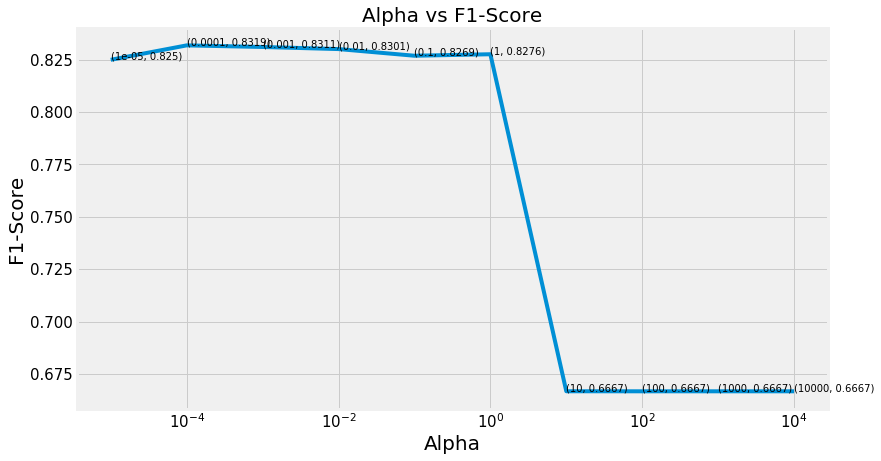

In [96]:
Scalar = StandardScaler()
Scalar.fit(Train)
TrainStd = Scalar.transform(Train)
CVStd = Scalar.transform(CV)
TestStd = Scalar.transform(Test)

alpha = [10**x for x in range(-5, 5)]

cv_f1_Score = []
for i in alpha:
    clf = SGDClassifier(loss = "log", alpha = i)
    clf.fit(TrainStd, TrainLabels)
    predicted_y = clf.predict(CVStd)
    cv_f1_Score.append(f1_score(CVLabels, predicted_y))
    print("For alpha value of "+str(i)+" CV F1 Score = "+str(f1_score(CVLabels, predicted_y)))

plt.figure(figsize = (12, 7))
plt.xscale('log')
plt.plot(alpha, cv_f1_Score)
for xy in zip(alpha, np.round(cv_f1_Score, 4)):
    plt.annotate(xy, xy)
    
plt.title("Alpha vs F1-Score", fontsize = 20)
plt.xlabel("Alpha", fontsize = 20)
plt.ylabel("F1-Score", fontsize = 20)
plt.show()

For values of best alpha = 0.0001, Test F1-Score = 0.8558497048718174, Test Accuracy Score = 85.46%


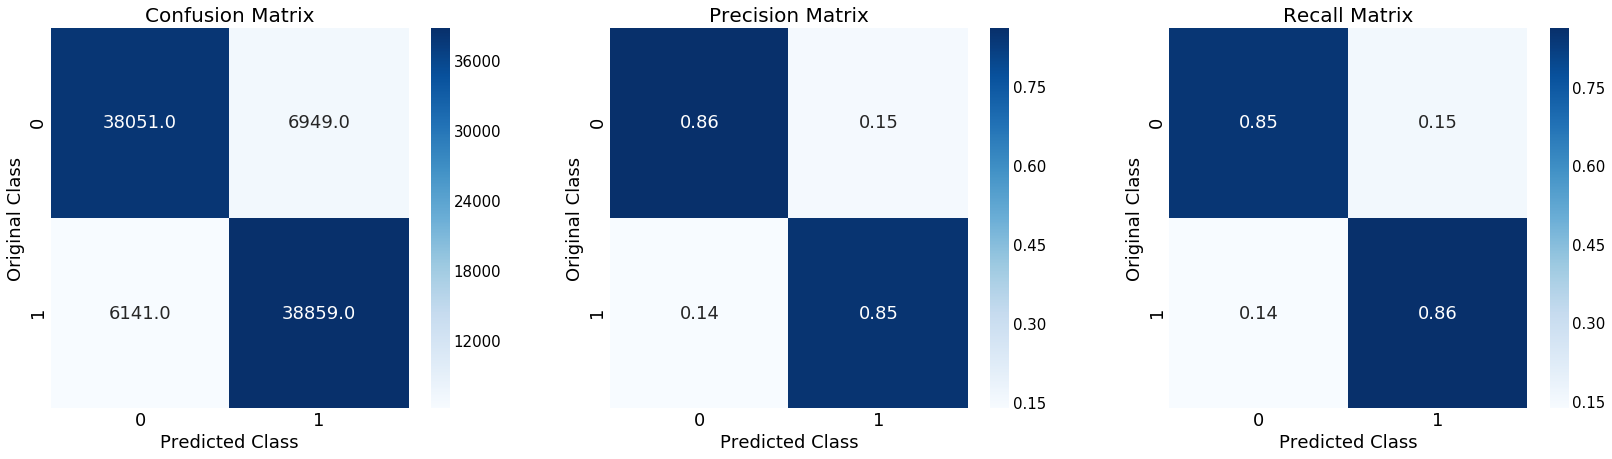

In [98]:

best_alpha = alpha[np.argmax(cv_f1_Score)]
clf = SGDClassifier(loss = "log", alpha = best_alpha)
clf.fit(TrainStd, TrainLabels)

predict_test = clf.predict(TestStd)
LR_F1_Score = f1_score(TestLabels, predict_test)
LR_Accuracy = accuracy_score(TestLabels, predict_test)
print('For values of best alpha = {}, Test F1-Score = {}, Test Accuracy Score = {}%'.format(best_alpha, LR_F1_Score, round((float(LR_Accuracy))*100,2)))
print_confusionMatrix(TestLabels, predict_test)

F1_Score.append(LR_F1_Score)
Accuracy_Scores.append(LR_Accuracy)

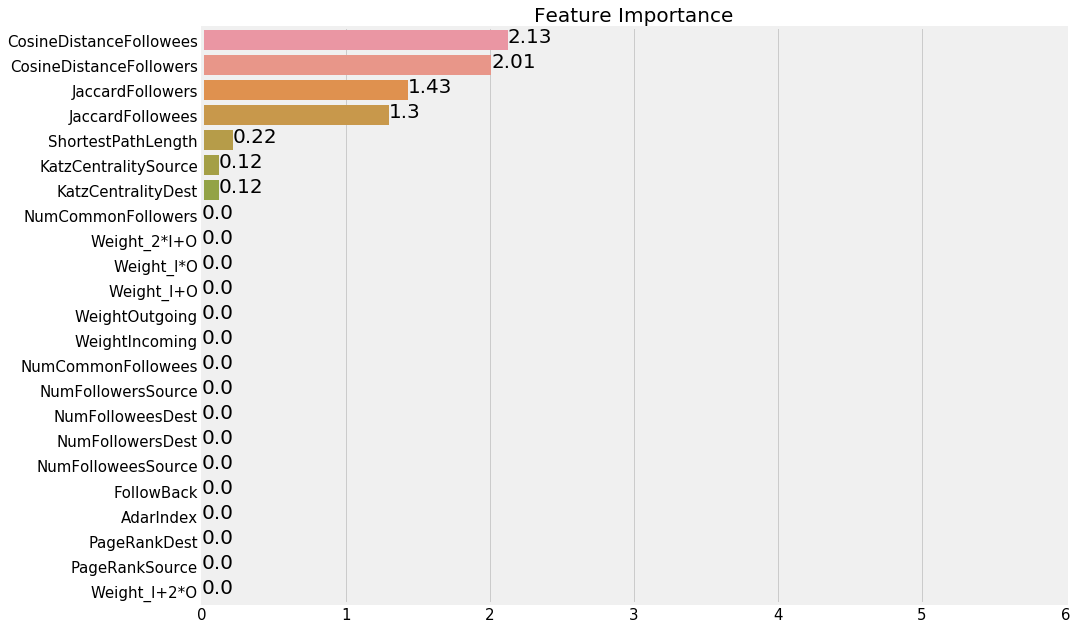

In [99]:
a = clf.coef_[0]
b = []
for i in a:
    if i>0:
        b.append(i)
    else:
        b.append(0)
imp_feat_df = pd.DataFrame({'Feature_Names':list(Train.columns), "Importance":list(b)})
imp_feat_df = imp_feat_df.sort_values("Importance", ascending = False)
fig = plt.figure(figsize = (12,8))
axes = fig.add_axes([0.1,0.1,1,1])
plt.title("Feature Importance")
sns.barplot(x = list(imp_feat_df['Importance']), y = list(imp_feat_df['Feature_Names']))
axes.set(xlim=(0, 6))
for i in axes.patches:
    axes.text(i.get_width(), i.get_y()+0.5, str(round(i.get_width(), 2)), fontsize=20, color='black')
plt.show()

__5.2 SVM__

For alpha value of 1e-07 CV F1 Score = 0.8280235743338591
For alpha value of 1e-06 CV F1 Score = 0.8243334354888139
For alpha value of 1e-05 CV F1 Score = 0.8473436016287641
For alpha value of 0.0001 CV F1 Score = 0.8466713881019831
For alpha value of 0.001 CV F1 Score = 0.8309326416871227
For alpha value of 0.01 CV F1 Score = 0.8307111969822432
For alpha value of 0.1 CV F1 Score = 0.8251655629139072
For alpha value of 1 CV F1 Score = 0.8024838649398438
For alpha value of 10 CV F1 Score = 0.002131060202450719
For alpha value of 100 CV F1 Score = 0.6666666666666666
For alpha value of 1000 CV F1 Score = 0.0
For alpha value of 10000 CV F1 Score = 0.0


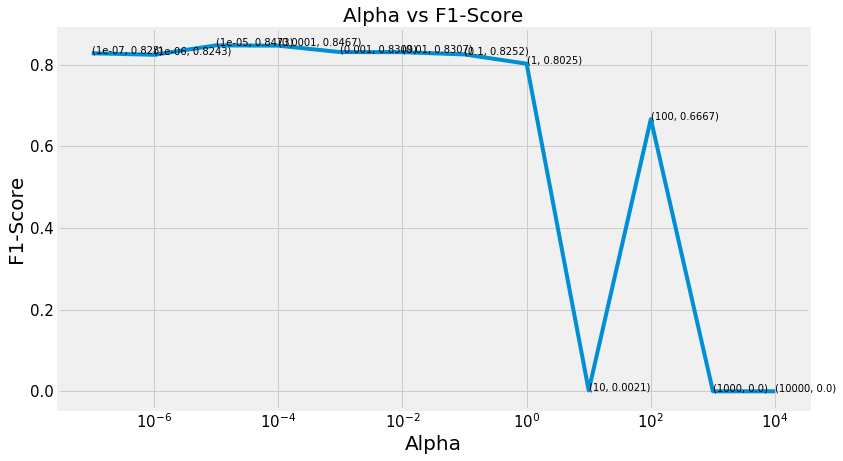

In [100]:
alpha = [10**x for x in range(-7, 5)]

cv_f1_Score = []
for i in alpha:
    clf = SGDClassifier(loss = "hinge", alpha = i)
    clf.fit(TrainStd, TrainLabels)
    predicted_y = clf.predict(CVStd)
    cv_f1_Score.append(f1_score(CVLabels, predicted_y))
    print("For alpha value of "+str(i)+" CV F1 Score = "+str(f1_score(CVLabels, predicted_y)))

plt.figure(figsize = (12, 7))
plt.xscale('log')
plt.plot(alpha, cv_f1_Score)
for xy in zip(alpha, np.round(cv_f1_Score, 4)):
    plt.annotate(xy, xy)
    
plt.title("Alpha vs F1-Score", fontsize = 20)
plt.xlabel("Alpha", fontsize = 20)
plt.ylabel("F1-Score", fontsize = 20)
plt.show()

For values of best alpha = 1e-05, Test F1-Score = 0.8324005103090663, Test Accuracy Score = 81.9%


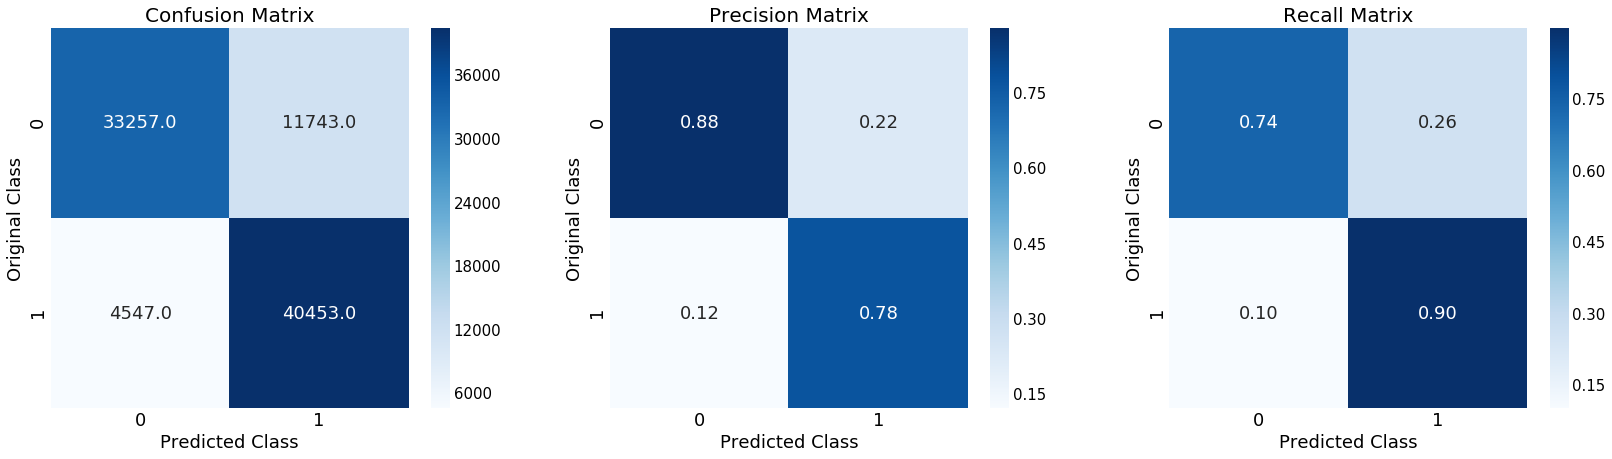

In [101]:
best_alpha = alpha[np.argmax(cv_f1_Score)]
clf = SGDClassifier(loss = "log", alpha = best_alpha)
clf.fit(TrainStd, TrainLabels)

predict_test = clf.predict(TestStd)
LR_F1_Score = f1_score(TestLabels, predict_test)
LR_Accuracy = accuracy_score(TestLabels, predict_test)
print('For values of best alpha = {}, Test F1-Score = {}, Test Accuracy Score = {}%'.format(best_alpha, LR_F1_Score, round((float(LR_Accuracy))*100,2)))
print_confusionMatrix(TestLabels, predict_test)

F1_Score.append(LR_F1_Score)
Accuracy_Scores.append(LR_Accuracy)

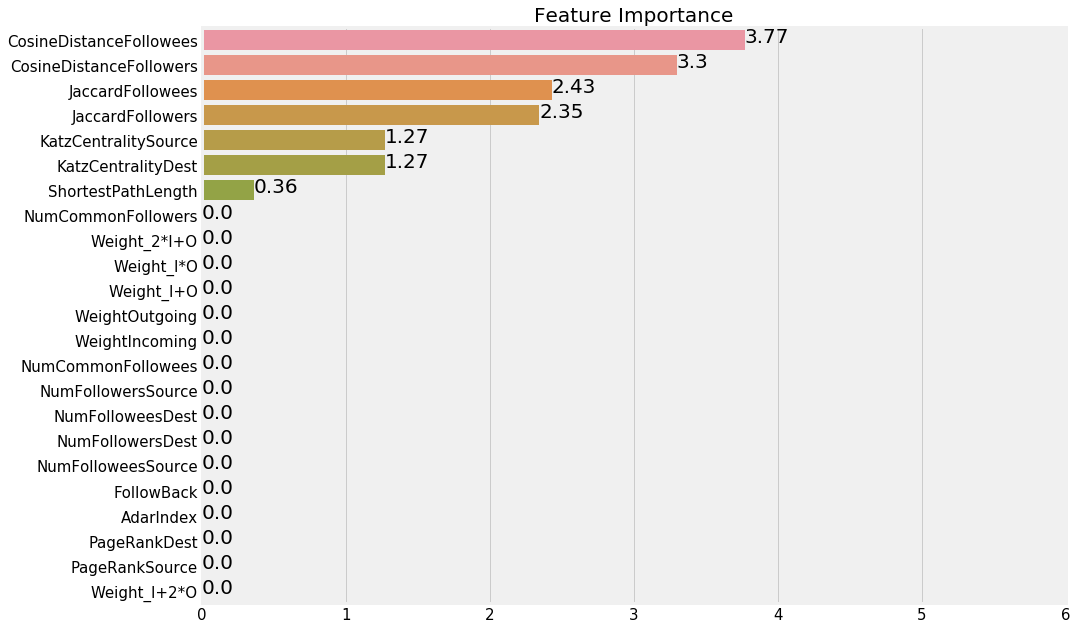

In [102]:
a = clf.coef_[0]
b = []
for i in a:
    if i>0:
        b.append(i)
    else:
        b.append(0)
imp_feat_df = pd.DataFrame({'Feature_Names':list(Train.columns), "Importance":list(b)})
imp_feat_df = imp_feat_df.sort_values("Importance", ascending = False)
fig = plt.figure(figsize = (12,8))
axes = fig.add_axes([0.1,0.1,1,1])
plt.title("Feature Importance")
sns.barplot(x = list(imp_feat_df['Importance']), y = list(imp_feat_df['Feature_Names']))
axes.set(xlim=(0, 6))
for i in axes.patches:
    axes.text(i.get_width(), i.get_y()+0.5, str(round(i.get_width(), 2)), fontsize=20, color='black')
plt.show()

__5.3 XGBoost__

In [103]:
def f1_error(y_pred, dtrain):
    y_true = dtrain.get_label()
    err = 1-f1_score(y_true, np.round(y_pred))
    return 'f1_err', err

params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(Train, label=TrainLabels)
d_test = xgb.DMatrix(CV, label=CVLabels)

watchlist = [(d_train, 'train'), (d_test, 'valid')]
bst = xgb.train(params, d_train, 500, watchlist, early_stopping_rounds=20, feval = f1_error, verbose_eval=10)

[0]	train-f1_err:0.142747	valid-f1_err:0.139592
Multiple eval metrics have been passed: 'valid-f1_err' will be used for early stopping.

Will train until valid-f1_err hasn't improved in 20 rounds.
[10]	train-f1_err:0.14079	valid-f1_err:0.137386
[20]	train-f1_err:0.14079	valid-f1_err:0.137386
Stopping. Best iteration:
[3]	train-f1_err:0.14079	valid-f1_err:0.137386



Test F1-Score = 0.8604455119692369, Test Accuracy Score = 86.57%


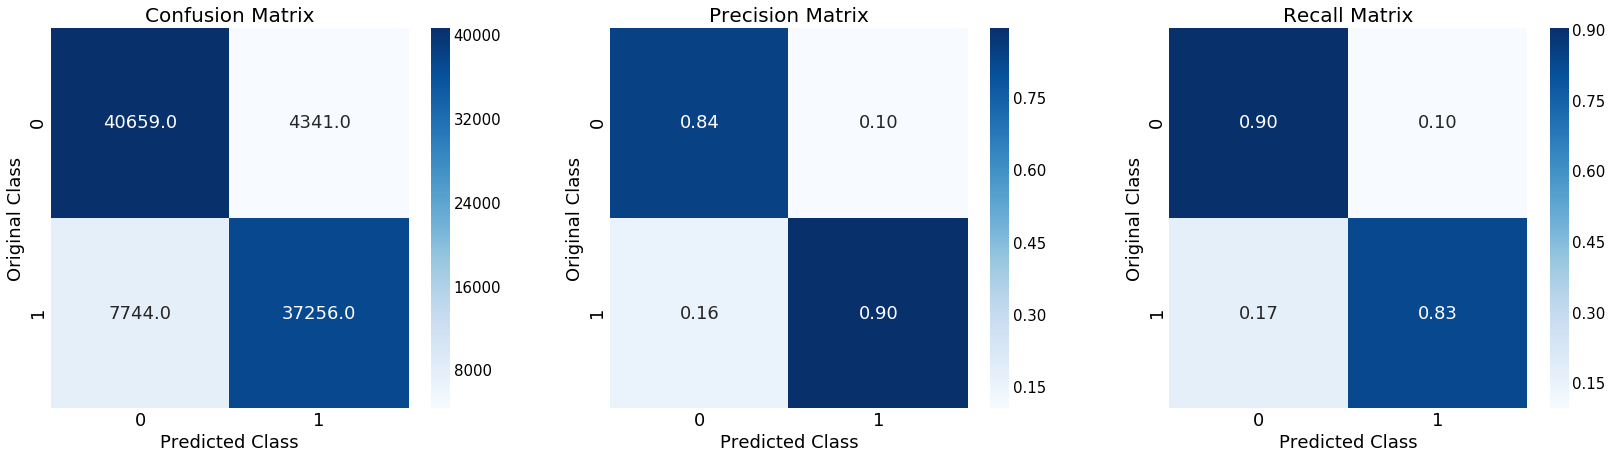

In [104]:
d_test = xgb.DMatrix(Test)
y_pred = list(map(lambda x: int(x>0.5), bst.predict(d_test)))
LR_F1_score = f1_score(TestLabels, y_pred)
LR_Accuracy = accuracy_score(TestLabels, y_pred)
print('Test F1-Score = {}, Test Accuracy Score = {}%'.format(LR_F1_score, round((float(LR_Accuracy))*100,2)))
print_confusionMatrix(TestLabels, y_pred)

F1_Score.append(LR_F1_score)
Accuracy_Scores.append(LR_Accuracy)

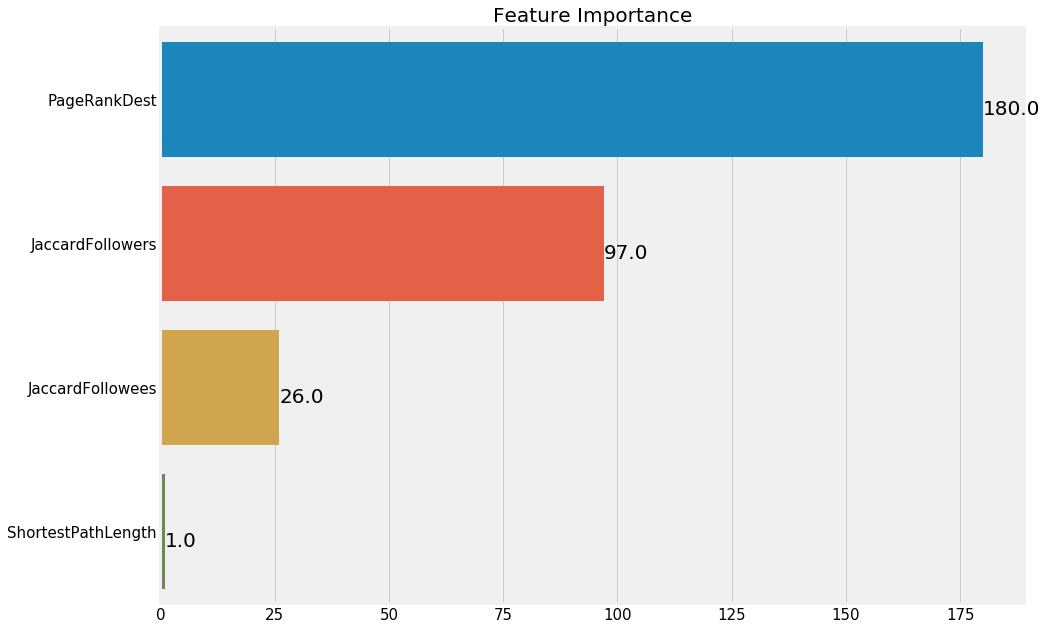

In [106]:
#here, only those feature values will be returned which xgboost has used for splitting. 
#In other words, all of the missing features are never used by xgboost for splitting decision tree.

imp_feats = bst.get_score(importance_type='weight')
imp_feat_df = pd.DataFrame({'Feature_Names':list(imp_feats.keys()), "Importance":list(imp_feats.values())})
imp_feat_df = imp_feat_df.sort_values("Importance", ascending = False)
fig = plt.figure(figsize = (12,8))
axes = fig.add_axes([0.1,0.1,1,1])
plt.title("Feature Importance")
sns.barplot(x = list(imp_feat_df['Importance']), y = list(imp_feat_df['Feature_Names']))
for i in axes.patches:
    axes.text(i.get_width(), i.get_y()+0.5, str(i.get_width()), fontsize=20, color='black')
plt.show()

In [107]:
df = pd.DataFrame({
    'Model': ["Logistic Regression", "SVC", "XGBoost"], 
    'Accuracy': Accuracy_Scores,
    'F1-Score': F1_Score
})
df


,Accuracy,F1-Score,Model
0,0.854556,0.855850,Logistic Regression
1,0.819000,0.832401,SVC
2,0.865722,0.860446,XGBoost


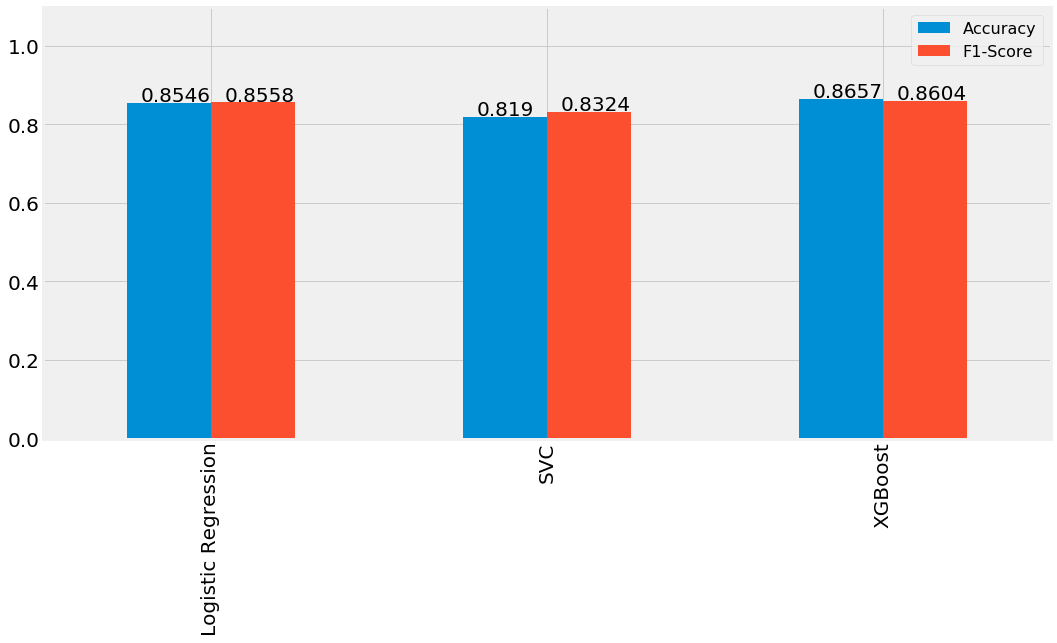

In [108]:
fig = plt.figure()
axes = fig.add_axes([0.1,0.1,1,1])
df.plot(x = 'Model', y = ['Accuracy', 'F1-Score'], figsize = (14, 6), kind = 'bar', ax = axes, grid = True)
plt.legend(fontsize = 16, loc = 0)
axes.set_xlabel("")
axes.set(ylim = (0,1.1))
axes.tick_params(labelsize = 20)
for i in axes.patches:
    axes.text(i.get_x()+0.04, i.get_height()+0.003, str(round(i.get_height(), 4)), fontsize=20, color='black')
plt.show()